In [37]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import math
import time

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.layers import LSTM, GRU
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.models import load_model
from datetime import date
from datetime import timedelta

training_start_time = time.time()

today = date.today()
data_end_date = today.strftime("%Y-%m-%d")
start_date = date.today() - timedelta(days=1095)
data_start_date = start_date.strftime("%Y-%m-%d")
df_data = yf.download('XRP-USD', start=data_start_date, end=data_end_date)

[*********************100%***********************]  1 of 1 completed


In [38]:
def move_close_to_first_column(df_data):
    df_data.drop(columns=['Adj Close'], inplace=True)
    close_price_column = df_data.pop('Close')
    df_data.insert(0, 'Close', close_price_column)
    return df_data

In [39]:
def prepare_ti_dataset(df_data):
    df_data.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Technical indicators",
        description="SMA 5, 10, 20, 30, 50, WMA 10, 20, 30, RSI, EMA, MACD",
        ta=[
            {"kind": "sma", "length": 5},
            {"kind": "sma", "length": 10},
            {"kind": "sma", "length": 20},
            {"kind": "sma", "length": 30},
            {"kind": "sma", "length": 50},
            {"kind": "wma", "length": 10},
            {"kind": "wma", "length": 20},
            {"kind": "wma", "length": 30},
            {"kind": "rsi"},
            {"kind": "ema"},
            {"kind": "macd", "fast": 8, "slow": 21},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [40]:
def prepare_combined_dataset(df_data):
    df_data.drop(columns=['Open', 'Volume'], inplace=True)
    CustomStrategy = ta.Strategy(
        name="Test",
        description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
        ta=[
            {"kind": "sma", "length": 5},
            {"kind": "wma", "length": 10},
            {"kind": "ema"},
        ]
    )

    df_data.ta.strategy(CustomStrategy)
    df_data = df_data.dropna()
    return df_data

In [41]:
df_data = move_close_to_first_column(df_data)
# df_data = prepare_ti_dataset(df_data)
# df_data = prepare_combined_dataset(df_data)

In [42]:
prediction_days = int(len(df_data)*0.2)

df_train = df_data[:len(df_data) - prediction_days]
df_test = df_data[len(df_data)-prediction_days:]

actual_test_df = df_test

columns_count = len(df_data.columns)
df_train = df_train.values.reshape(-1, columns_count)
df_test = df_test.values.reshape(-1, columns_count)

# Normalize data
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

result_scaler = MinMaxScaler(feature_range=(0, 1))
result_scaler.fit_transform(df_test[:, 0:1])

array([[0.23032486],
       [0.21021532],
       [0.2105111 ],
       [0.24181386],
       [0.23980789],
       [0.21121577],
       [0.22921157],
       [0.25604356],
       [0.2471446 ],
       [0.24952167],
       [0.22378294],
       [0.27678244],
       [0.17481788],
       [0.13284101],
       [0.06899695],
       [0.1273322 ],
       [0.10816296],
       [0.09877767],
       [0.1206474 ],
       [0.1006933 ],
       [0.11280673],
       [0.14641378],
       [0.1417449 ],
       [0.12650728],
       [0.10803757],
       [0.10799998],
       [0.10434664],
       [0.09952988],
       [0.1151436 ],
       [0.09445485],
       [0.07142409],
       [0.01764226],
       [0.02008203],
       [0.02255184],
       [0.        ],
       [0.02216318],
       [0.00758249],
       [0.00998206],
       [0.01424973],
       [0.04900265],
       [0.06697341],
       [0.09633536],
       [0.11559996],
       [0.11835567],
       [0.08944245],
       [0.09960005],
       [0.10920099],
       [0.079

In [43]:
# Dataset Generator for LSTM
def dataset_generator(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 1:]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

In [44]:
look_back_period = 15
trainX, trainY = dataset_generator(scaled_train, look_back_period)
testX, testY = dataset_generator(scaled_test, look_back_period)

In [45]:
def get_lstm_model(timesteps_count, features_count):
    regressor = Sequential()
    regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (timesteps_count, features_count)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 64, input_shape = (timesteps_count, features_count)))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    regressor.summary()
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

In [46]:
timesteps_count = trainX.shape[1]
features_count = trainX.shape[2]
regressor = get_lstm_model(timesteps_count, features_count)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 15, 128)           68096     
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 117,569
Trainable params: 117,569
Non-trainable params: 0
_________________________________________________________________


In [47]:
checkpoint_path = 'lstm-checkpoint.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
27/27 [==============================] - 4s 33ms/step - loss: 0.0297 - val_loss: 0.0413

Epoch 00001: val_loss improved from inf to 0.04127, saving model to lstm-checkpoint.hdf5
Epoch 2/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0269 - val_loss: 0.0197

Epoch 00002: val_loss improved from 0.04127 to 0.01967, saving model to lstm-checkpoint.hdf5
Epoch 3/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0099 - val_loss: 0.0270

Epoch 00003: val_loss did not improve from 0.01967
Epoch 4/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0120 - val_loss: 0.0186

Epoch 00004: val_loss improved from 0.01967 to 0.01857, saving model to lstm-checkpoint.hdf5
Epoch 5/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0061 - val_loss: 0.0185

Epoch 00005: val_loss improved from 0.01857 to 0.01845, saving model to lstm-checkpoint.hdf5
Epoch 6/600
27/27 [==============================] - 0s 18ms/step - loss: 0.

27/27 [==============================] - 0s 18ms/step - loss: 0.0027 - val_loss: 0.0084

Epoch 00047: val_loss did not improve from 0.00837
Epoch 48/600
27/27 [==============================] - 1s 20ms/step - loss: 0.0025 - val_loss: 0.0083

Epoch 00048: val_loss improved from 0.00837 to 0.00830, saving model to lstm-checkpoint.hdf5
Epoch 49/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0082

Epoch 00049: val_loss improved from 0.00830 to 0.00816, saving model to lstm-checkpoint.hdf5
Epoch 50/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0023 - val_loss: 0.0080

Epoch 00050: val_loss improved from 0.00816 to 0.00800, saving model to lstm-checkpoint.hdf5
Epoch 51/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0025 - val_loss: 0.0092

Epoch 00051: val_loss did not improve from 0.00800
Epoch 52/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0027 - val_loss: 0.0094

Epoch 00052: val_los

27/27 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0072

Epoch 00097: val_loss did not improve from 0.00679
Epoch 98/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0072

Epoch 00098: val_loss did not improve from 0.00679
Epoch 99/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0018 - val_loss: 0.0073

Epoch 00099: val_loss did not improve from 0.00679
Epoch 100/600
27/27 [==============================] - 0s 18ms/step - loss: 0.0018 - val_loss: 0.0072

Epoch 00100: val_loss did not improve from 0.00679
Epoch 101/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0068

Epoch 00101: val_loss did not improve from 0.00679
Epoch 102/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0016 - val_loss: 0.0070

Epoch 00102: val_loss did not improve from 0.00679
Epoch 103/600
27/27 [==============================] - 1s 19ms/step - loss: 0.0016 - val_los

In [48]:
training_time = time.time() - training_start_time
predicting_start_time = time.time()

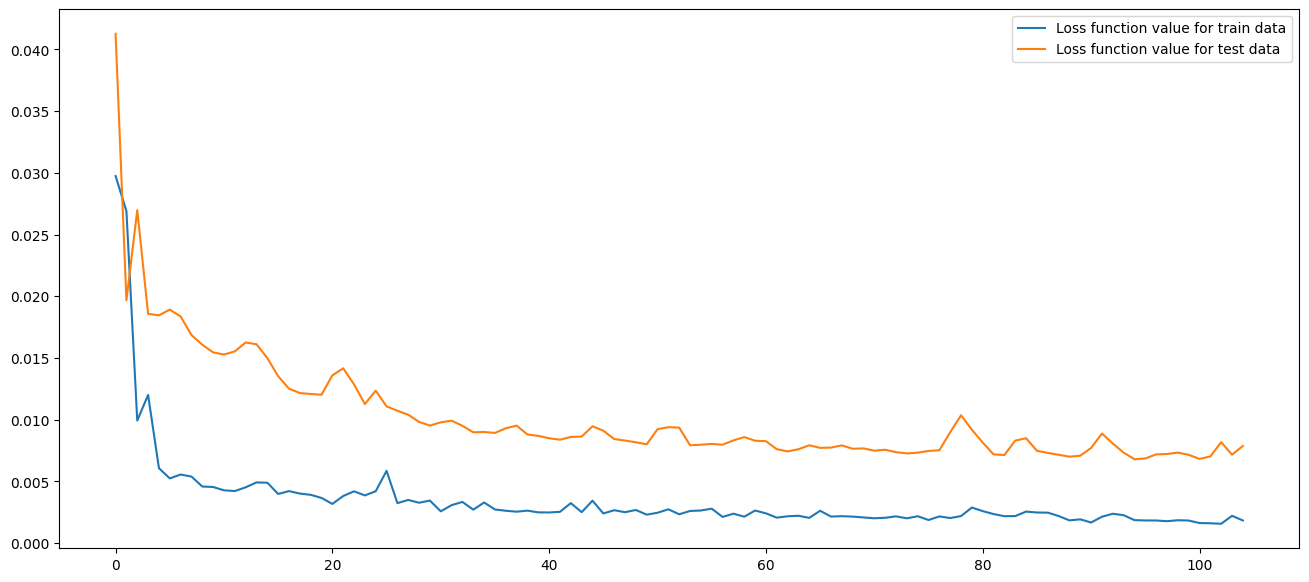

In [49]:
# Plot line graph to show Loss Numbers relative to the epoch
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='Loss function value for train data')

plt.plot(history.history['val_loss'], label='Loss function value for test data')
plt.legend()
plt.show()

In [50]:
model_from_saved_checkpoint = load_model(checkpoint_path)

# Prediction for the existing data
predicted_price = model_from_saved_checkpoint.predict(testX)

predicted_price = result_scaler.inverse_transform(predicted_price.reshape(-1, 1))
test_actual = result_scaler.inverse_transform(testY.reshape(-1, 1))

df_data_len = len(df_data)
date_range = df_data[df_data_len-len(predicted_price):].index

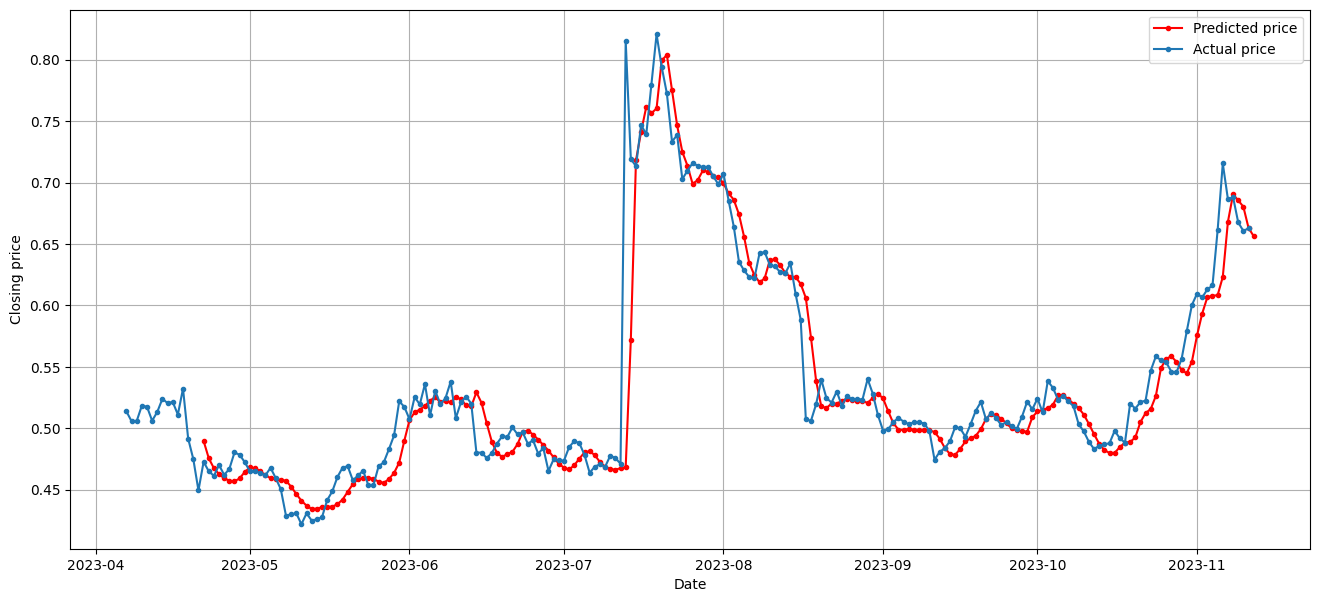

In [51]:
# Predicting next day price
x_input = scaled_test[-look_back_period:, 1:]
x_input = x_input.reshape(1, look_back_period, features_count)

prediction_for_next_day = model_from_saved_checkpoint.predict(x_input)
next_day_price = result_scaler.inverse_transform(prediction_for_next_day.reshape(-1, 1))
next_day_price = next_day_price.reshape(-1)[0]

date_range = actual_test_df.index.tolist()
date_range.append(date.today())

predicted_prices = predicted_price.reshape(-1).tolist()
predicted_prices_with_next_day = predicted_prices
predicted_prices_with_next_day.append(next_day_price)

predicted_prices_for_plot = np.empty_like(date_range)
predicted_prices_for_plot[:] = np.nan
predicted_prices_for_plot[look_back_period:] = predicted_prices_with_next_day

actual_prices = actual_test_df['Close'].values.tolist()
actual_prices.append(np.nan)

plt.figure(figsize=(16,7))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing price')

plt.plot(date_range, predicted_prices_for_plot, 'r', marker='.', label='Predicted price')

plt.plot(date_range, actual_prices, marker='.', label='Actual price')

plt.legend()
plt.show()

In [52]:
predicting_time = time.time() - predicting_start_time

# report performance
model_predictions = predicted_price
testing_data = test_actual
mape = np.mean(np.abs(np.array(model_predictions) - np.array(testing_data))/np.abs(testing_data))
mape_percentage = mape * 100
model_accuracy = 100 - mape_percentage
rmse = math.sqrt(mean_squared_error(test_actual, predicted_price))

print('MAPE: %.2f %%' % mape_percentage)
print('Model accuracy: %.2f %%' % model_accuracy)
print('RMSE: %.3f' % rmse)
print('Training time: %.2f in seconds' % training_time)
print('Predicting time: %.2f in seconds' % predicting_time)

MAPE: 2.77 %
Model accuracy: 97.23 %
RMSE: 0.033
Training time: 59.86 in seconds
Predicting time: 0.92 in seconds


In [53]:
from tqdm.notebook import tqdm

results = []
print(' Computing LSTM feature importance...')

# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = model_from_saved_checkpoint.predict(testX, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-testY ))
results.append({'feature':'BASELINE','mae':baseline_mae})
COLS = list(df_data.loc[:, df_data.columns != 'Close'].columns)

for k in tqdm(range(len(COLS))):           
    # SHUFFLE FEATURE K
    save_col = testX[:,:,k].copy()
    np.random.shuffle(testX[:,:,k])

    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model_from_saved_checkpoint.predict(testX, verbose=0).squeeze() 
    mae = np.mean(np.abs( oof_preds-testY ))
    results.append({'feature':COLS[k],'mae':mae})
    testX[:,:,k] = save_col
    

 Computing LSTM feature importance...


  0%|          | 0/4 [00:00<?, ?it/s]

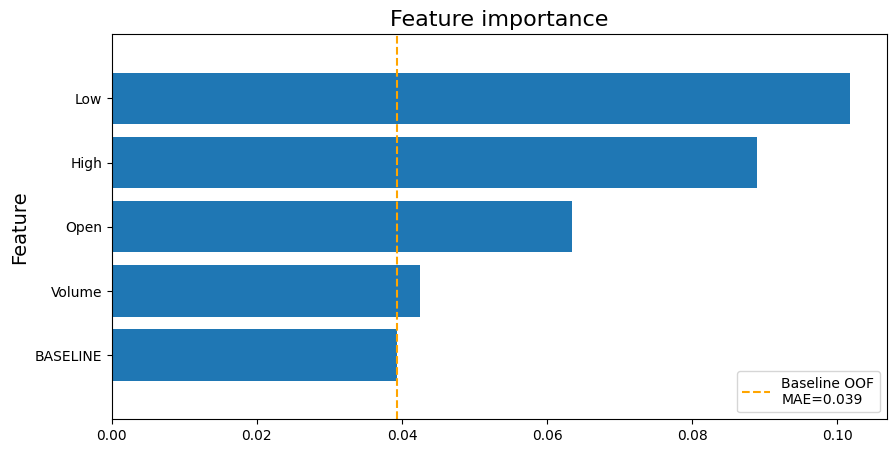

In [54]:
# DISPLAY LSTM FEATURE IMPORTANCE
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,5))
plt.barh(np.arange(len(COLS)+1),df.mae)
plt.yticks(np.arange(len(COLS)+1),df.feature.values)
plt.title('Feature importance',size=16)
plt.ylim((-1,len(COLS)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()